In [2]:
import pandas as pd
import numpy as np
import os
import time
from decimal import Decimal 

root_path = R'.\data'

def adjust_path(path):
    zero_index = path.index(0)
    shifted_path = path[zero_index:] + path[:zero_index]
    
    if shifted_path[-1] != 0:
        shifted_path.append(0)
    
    return shifted_path


def load_all_data_to_df():
    all_data = {}

    algorithms = [d for d in os.listdir(root_path) if os.path.isdir(os.path.join(root_path, d))]
    
    for algo in algorithms:
        all_data[algo] = {}
        algo_path = os.path.join(root_path, algo)

        iters = [d for d in os.listdir(algo_path) if os.path.isdir(os.path.join(algo_path, d))]
        
        for iter in iters:
            iter_path = os.path.join(algo_path, iter)
            iterations_file_path = os.path.join(iter_path, 'iterations.csv')

            iter_df = pd.read_csv(iterations_file_path, sep=';', header=None, dtype={1: str, 2: str})
            iter_df.columns = ['pid', 'start_time', 'elapsed_time', 'iteration', 'cost', 'path']
            iter_df['path'] = iter_df['path'].apply(lambda x: adjust_path(eval(x)))
            iter_df['iters'] = [None] * len(iter_df)
            iter_df['start_time'] = iter_df['start_time'].apply(Decimal)
            iter_df['elapsed_time'] = iter_df['elapsed_time'].apply(Decimal)
            
            for idx, row in iter_df.iterrows():
                file_name = F"{row['pid']}_{row['start_time']}_{row['elapsed_time']}.csv"
                file_path = os.path.join(iter_path, file_name)
                
                if os.path.isfile(file_path):
                    run_df = pd.read_csv(file_path, sep=';', header=None)
                    run_df.columns = ['iteration', 'cost', 'path']
                    run_df['path'] = run_df['path'].apply(lambda x: adjust_path(eval(x)))
                    iter_df.at[idx, 'iters'] = run_df.to_dict('records') 
                else:
                    print(file_path)

            all_data[algo][iter] = iter_df

    return all_data



In [3]:
data = load_all_data_to_df()

In [4]:
data['ACO']['300'].head(1)

,pid,start_time,elapsed_time,iteration,cost,path,iters
0,4,1702107674.7464526,69.86590790748596,99,377,"[0, 51, 52, 41, 27, 54, 22, 21, 14, 15, 13, 12...","[{'iteration': 0, 'cost': 607, 'path': [0, 5, ..."


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

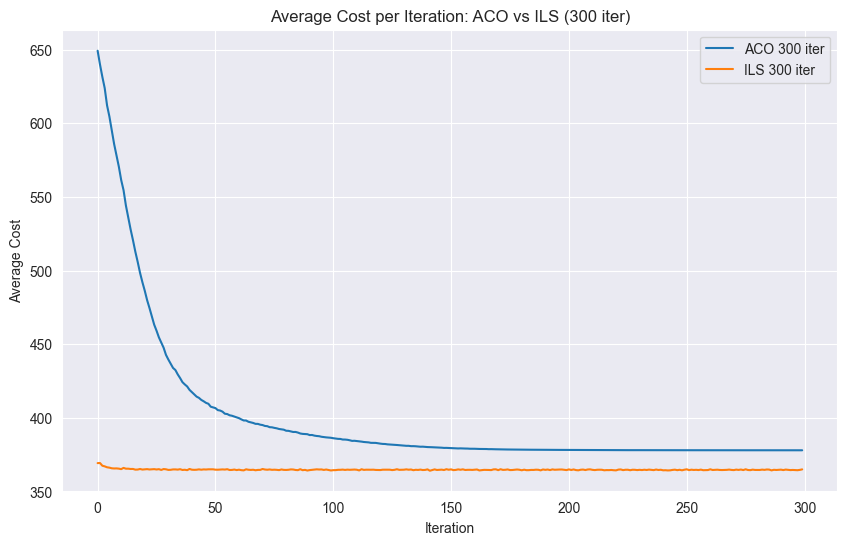

In [6]:
aco_iter_data = data['ACO']['300']
ils_iter_data = data['ILS']['300']

def average_cost_per_iteration(iter_data):
    total_costs = []
    for index, row in iter_data.iterrows():
        iter_costs = [d['cost'] for d in row['iters']]
        total_costs.append(iter_costs)
    return np.mean(total_costs, axis=0)

aco_avg_costs = average_cost_per_iteration(aco_iter_data)
ils_avg_costs = average_cost_per_iteration(ils_iter_data)

plt.figure(figsize=(10, 6))
plt.plot(aco_avg_costs, label='ACO 300 iter')
plt.plot(ils_avg_costs, label='ILS 300 iter')
plt.xlabel('Iteration')
plt.ylabel('Average Cost')
plt.title('Average Cost per Iteration: ACO vs ILS (300 iter)')
plt.legend()
plt.grid(True)
plt.show()

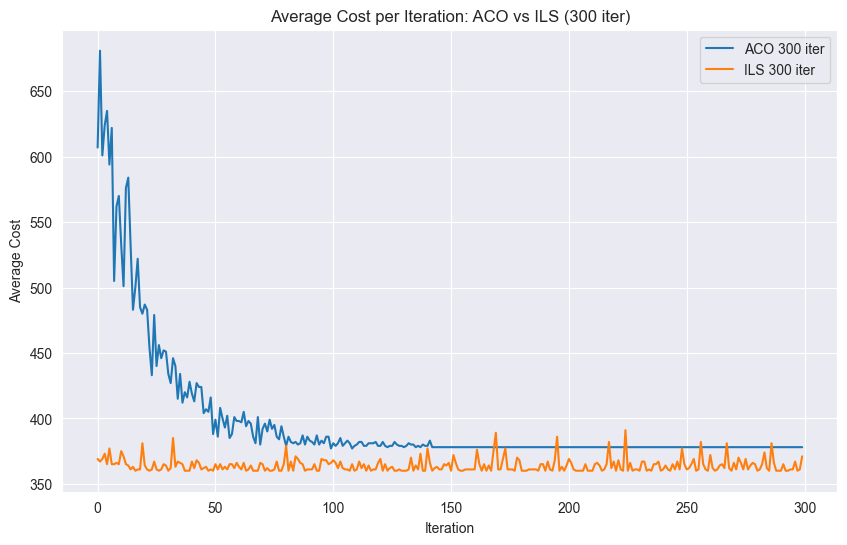

In [7]:
aco_iter_data = data['ACO']['300'].head(1)
ils_iter_data = data['ILS']['300'].head(1)

def average_cost_per_iteration(iter_data):
    total_costs = []
    for index, row in iter_data.iterrows():
        iter_costs = [d['cost'] for d in row['iters']]
        total_costs.append(iter_costs)
    return np.mean(total_costs, axis=0)

aco_avg_costs = average_cost_per_iteration(aco_iter_data)
ils_avg_costs = average_cost_per_iteration(ils_iter_data)

plt.figure(figsize=(10, 6))
plt.plot(aco_avg_costs, label='ACO 300 iter')
plt.plot(ils_avg_costs, label='ILS 300 iter')
plt.xlabel('Iteration')
plt.ylabel('Average Cost')
plt.title('Average Cost per Iteration: ACO vs ILS (300 iter)')
plt.legend()
plt.grid(True)
plt.show()

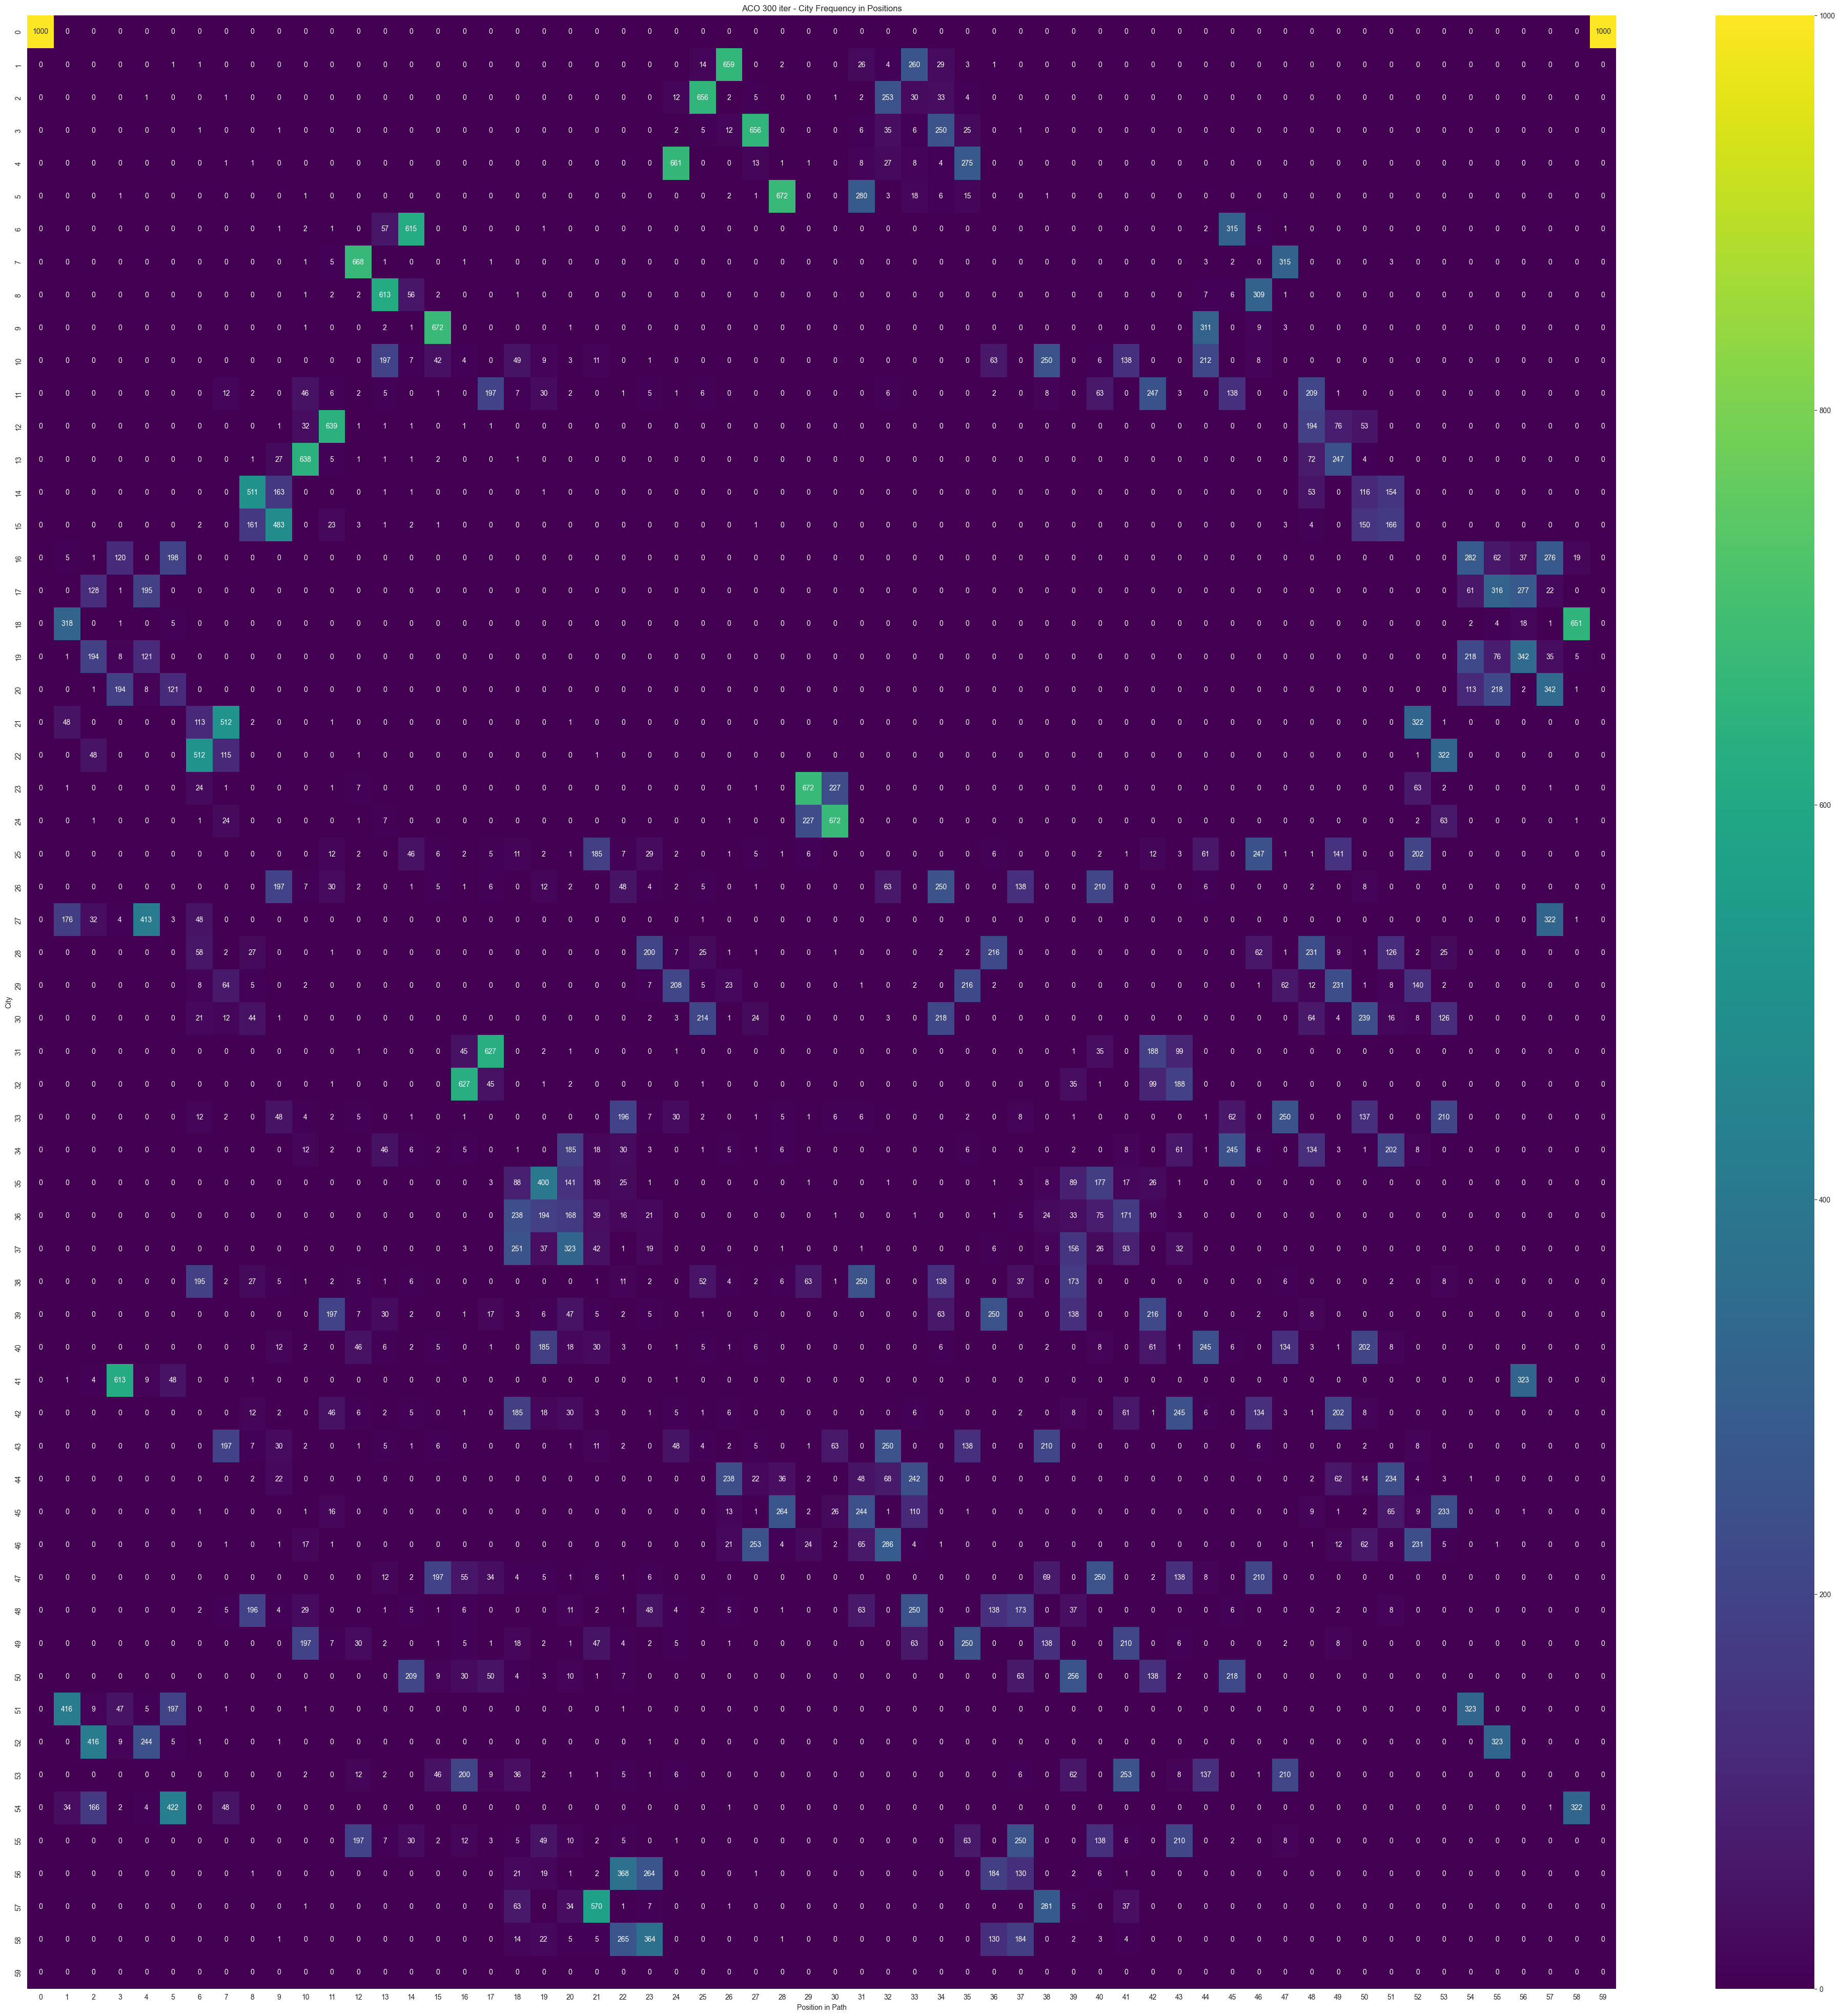

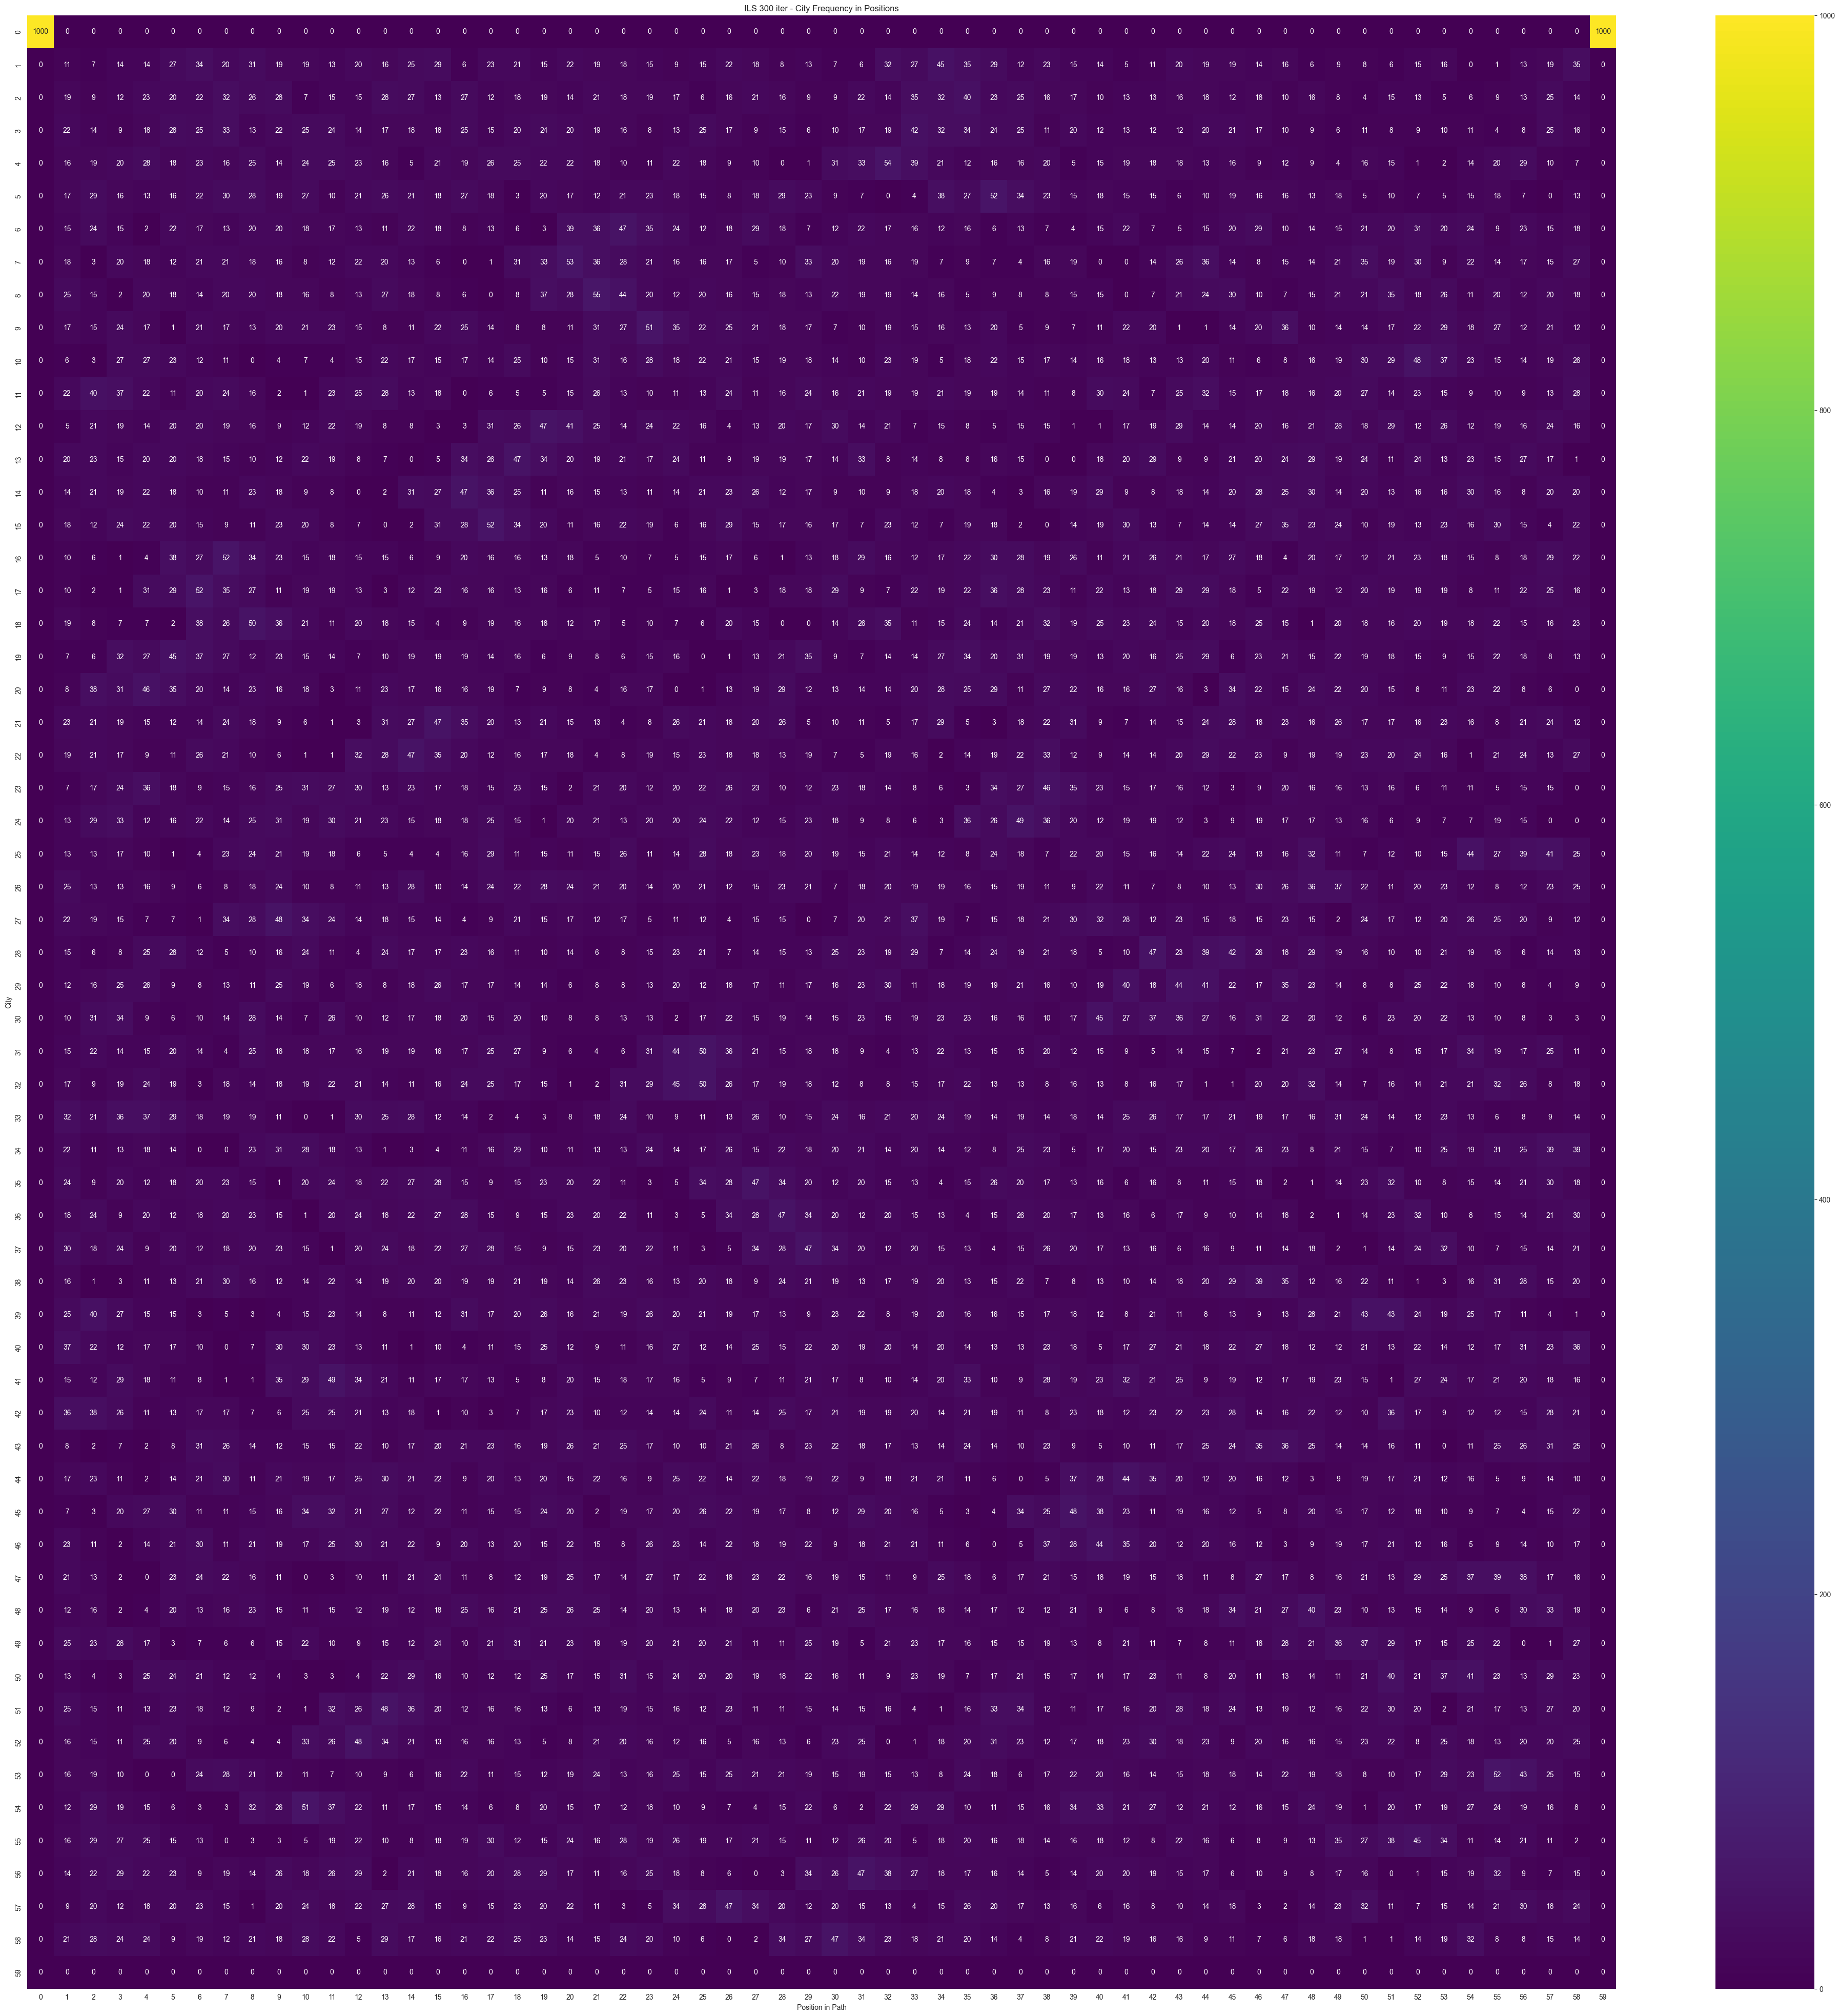

In [8]:
aco_iter_data = data['ACO']['300']
ils_iter_data = data['ILS']['300']

def create_heatmap(iter_data, title):
    num_cities = len(iter_data['path'][0])

    city_freq = np.zeros((num_cities, num_cities))

    for path in iter_data['path']:
        for position, city in enumerate(path):
            city_freq[city][position] += 1

    plt.figure(figsize=(50, 50))
    sns.heatmap(city_freq.astype(int), annot=True, cmap='viridis', fmt='d')
    plt.title(title)
    plt.xlabel('Position in Path')
    plt.ylabel('City')
    plt.show()

create_heatmap(aco_iter_data, 'ACO 300 iter - City Frequency in Positions')
create_heatmap(ils_iter_data, 'ILS 300 iter - City Frequency in Positions')


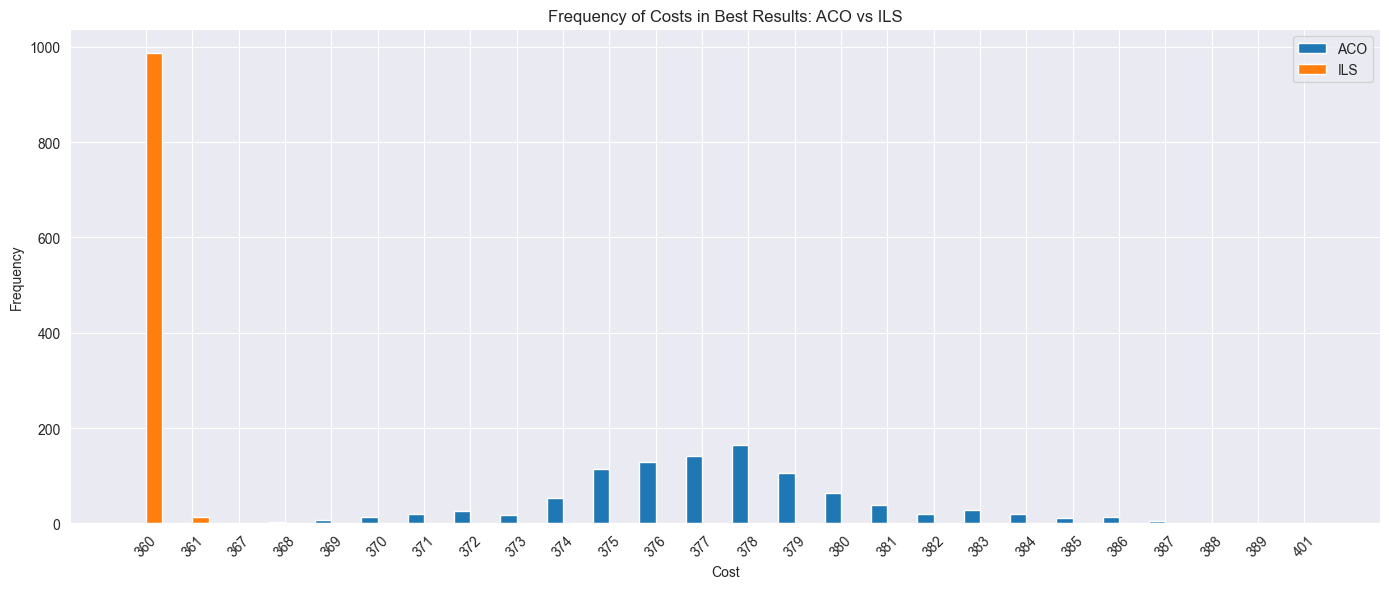

In [16]:
aco_iter_data = data['ACO']['300']
ils_iter_data = data['ILS']['300']

all_costs = sorted(set(aco_iter_data['cost']).union(set(ils_iter_data['cost'])))

aco_freq = [(aco_iter_data['cost'] == cost).sum() for cost in all_costs]
ils_freq = [(ils_iter_data['cost'] == cost).sum() for cost in all_costs]

x = np.arange(len(all_costs))
width = 0.35

plt.figure(figsize=(14, 6))
plt.bar(x - width/2, aco_freq, width, label='ACO')
plt.bar(x + width/2, ils_freq, width, label='ILS')

plt.xlabel('Cost')
plt.ylabel('Frequency')
plt.title('Frequency of Costs in Best Results: ACO vs ILS')
plt.xticks(x, all_costs, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

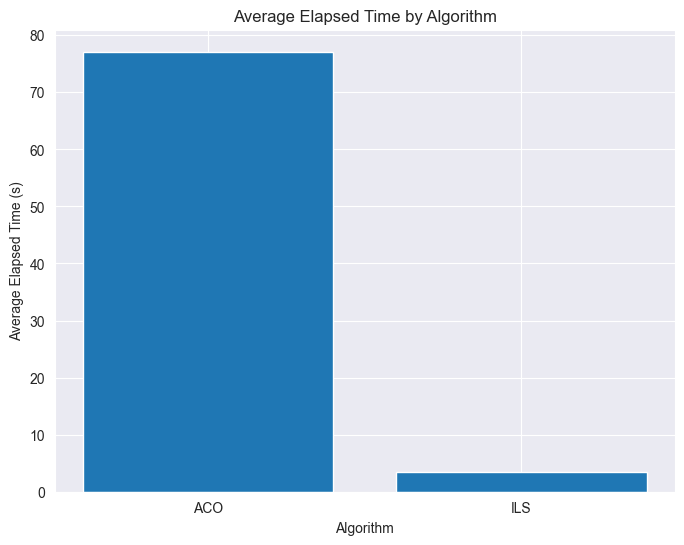

In [17]:
aco_avg_elapsed_time = data['ACO']['300']['elapsed_time'].mean()
ils_avg_elapsed_time = data['ILS']['300']['elapsed_time'].mean()

plt.figure(figsize=(8, 6))
plt.bar(['ACO', 'ILS'], [aco_avg_elapsed_time, ils_avg_elapsed_time])
plt.xlabel('Algorithm')
plt.ylabel('Average Elapsed Time (s)')
plt.title('Average Elapsed Time by Algorithm')
plt.show()